# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

В первой ячейке библиотеки которые понадобятся в ходе выполнения проекта.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

state = np.random.RandomState(12345)

Подгрузим данные в проект.

In [3]:
try:
    geo_gata_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_gata_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_gata_2 = pd.read_csv('/datasets/geo_data_2.csv')
except Exception:
    geo_gata_0 = pd.read_csv('geo_data_0.csv')
    geo_gata_1 = pd.read_csv('geo_data_1.csv')
    geo_gata_2 = pd.read_csv('geo_data_2.csv')

После получения датафремов проанализируем один, а для двух остальных сделаем проверку по аналогии.

In [3]:
geo_gata_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


Описание данных:

* id -  уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

In [4]:
geo_gata_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


С названиями столбцов всё в порядке, типы данных соответствуют содержимому ячеек. Пропусков в данных нет, но возможно есть дубликаты.

In [5]:
geo_gata_0.duplicated().sum()

0

Полных дубликатов нет, проверим есть ли объеты с одинаковым `id`.

In [6]:
geo_gata_0['id'].duplicated().sum()

10

Десять из десяти, тысячь. Так как мы зарание проверили что полных дубликатов нет, то понимаем что совпадают только имена объектов. Чтобы не путать модель, удалим эти объекты. Так как признаки имеют одно название, но разные характеристики объекта, то делать вывод о том какие верные мы не можем, удалим пары дубликатов.

In [7]:
geo_gata_0.drop(index=geo_gata_0[geo_gata_0.duplicated('id', keep=False)].index, axis=1, inplace=True)
geo_gata_0.reset_index(drop=True, inplace=True)


In [8]:
geo_gata_0.describe()

,f0,f1,f2,product
count,99980.000000,99980.000000,99980.000000,99980.000000
mean,0.500447,0.250147,2.502638,92.499166
std,0.871879,0.504431,3.248056,44.289044
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072674,-0.200869,0.288010,56.496513
50%,0.502374,0.250252,2.516005,91.847928
75%,1.073692,0.700646,4.714884,128.564089
max,2.362331,1.343769,16.003790,185.364347


Посмотрим на разброс значений.

<AxesSubplot:>

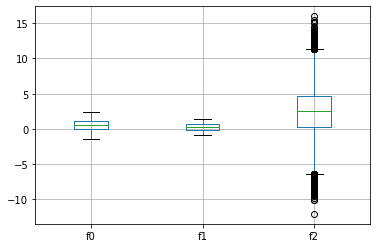

In [9]:
geo_gata_0.boxplot(['f0', 'f1', 'f2'])

В столбце "f2" есть выбросы. Они будут мешать обучению модели поэтому их лучше удалить. Удаление выбросов будем производить с помощью ящичного анализа. Для этого найдём первый и третий квантили. Эти значения можно взять из вывода функции `describe()`, но всегда лучше получать значения через вычисления. В будующем это позволит автоматизировать расчёты и избавиться от рутинной работы.

In [10]:
q25=np.array(geo_gata_0['f2'].quantile(0.25))
q75=np.array(geo_gata_0['f2'].quantile(0.75))
print('25% -', q25)
print('75% -', q75)

25% - 0.28800973629057447
75% - 4.714884192523504


Результаты совпадают с выводом функции `describe()`, значит мы всё делаем правильно. Следующим шагом найдём верхний предел - максимальное значение в ненормальном диапазоне. Верхний предел = Q3 + 1,5 * IQR, где IQR - межквартильный размах определяющийся как разница третьего и первого квартилей.

In [11]:
upper_limit=q75+1.5*(q75-q25)

Аналогично определим нижний предел, он будет на сигму меньше.

In [12]:
lower_limit=q25-1.5*(q75-q25)

Определим количество значений (выбросов) находятся за пределами диапазона.

In [13]:
del_data = 0 # Переменная-счётчик
for index_value, value in zip(geo_gata_0['f2'].index,geo_gata_0['f2']): # Перебираем индексы и значения
    if upper_limit <= value or value <= lower_limit:
        del_data += 1
    
print(f'Количество строк для удаления: {del_data} или {round(del_data / len(geo_gata_0) * 100,1)}%')

Количество строк для удаления: 507 или 0.5%


Меньше одного процента, таким количеством можно пожертвовать ради повышения качества обучения модели. Удалим данные. Для удобства соберём код выше в функцию.

In [14]:
def remove_unnecessary(df, column):
    q25=np.array(df[column].quantile(0.25))
    q75=np.array(df[column].quantile(0.75))
    lower_limit=q25-1.5*(q75-q25)
    upper_limit=q75+1.5*(q75-q25)
    del_data = 0
    for index_value, value in zip(df[column].index,df[column]):
        if upper_limit <= value or value <= lower_limit:
            del_data += 1
            df.drop(index_value, axis = 0, inplace = True)
    
    print(f'Количество удалённых строк: {del_data} или {round(del_data / len(df) * 100,1)}%')
    return df.reset_index(drop = True)

In [15]:
geo_gata_0 = remove_unnecessary(geo_gata_0, 'f2')

Количество удалённых строк: 507 или 0.5%


Построим диаграмму размаха для целевого признака.

<AxesSubplot:>

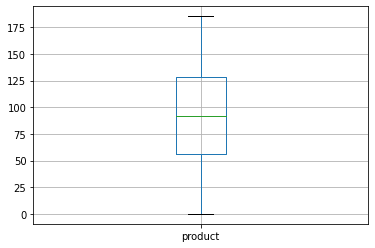

In [16]:
geo_gata_0.boxplot(['product'])

Выбросов нет, все данные попадают в межквартильный размах, медиана незначительно отличается от среднего. Проверим наличие корреляции.

In [17]:
geo_gata_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440718,-0.003382,0.143568
f1,-0.440718,1.000000,0.001161,-0.192732
f2,-0.003382,0.001161,1.000000,0.480093
product,0.143568,-0.192732,0.480093,1.000000


Из таблицы видно что "f0" отрицательно коррелирует с "f1", а "f2" коррелирует с целевым признаком.

Быспро проведём аналогичный анализ для оставшихся таблиц.

In [18]:
geo_gata_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [19]:
geo_gata_1.duplicated().sum()

0

In [20]:
geo_gata_1['id'].duplicated().sum()

4

In [21]:
geo_gata_1.drop(index=geo_gata_1[geo_gata_1.duplicated('id', keep=False)].index, axis=1, inplace=True)
geo_gata_1.reset_index(drop=True, inplace=True)

In [22]:
geo_gata_1.describe()

,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,1.141363,-4.796522,2.494511,68.824148
std,8.965805,5.119934,1.703587,45.944889
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298525,-8.267985,1.000021,26.953261
50%,1.153190,-4.813005,2.011475,57.085625
75%,8.620964,-1.332704,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<AxesSubplot:>

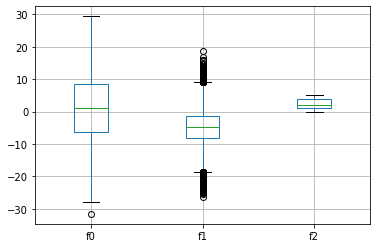

In [23]:
geo_gata_1.boxplot(['f0', 'f1', 'f2'])

Удаляем выбросы из столбцов "f0" и "f1" c помощью функции "remove_unnecessary".

In [24]:
geo_gata_1 = remove_unnecessary(geo_gata_1, 'f0')

Количество удалённых строк: 1 или 0.0%


In [25]:
geo_gata_1 = remove_unnecessary(geo_gata_1, 'f1')

Количество удалённых строк: 636 или 0.6%


<AxesSubplot:>

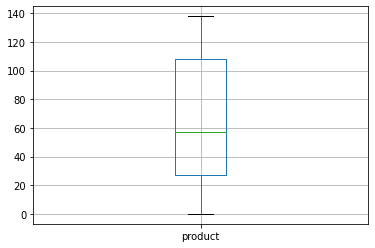

In [26]:
geo_gata_1.boxplot('product')

In [27]:
geo_gata_1.corr()

,f0,f1,f2,product
f0,1.000000,0.178911,-0.001682,-0.030401
f1,0.178911,1.000000,-0.002780,-0.010199
f2,-0.001682,-0.002780,1.000000,0.999397
product,-0.030401,-0.010199,0.999397,1.000000


Переходим к следующему.

In [29]:
geo_gata_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [30]:
geo_gata_2.duplicated().sum()

0

In [31]:
geo_gata_2['id'].duplicated().sum()

4

In [32]:
geo_gata_2.drop(index=geo_gata_2[geo_gata_2.duplicated('id', keep=False)].index, axis=1, inplace=True)
geo_gata_2.reset_index(drop=True, inplace=True)

In [33]:
geo_gata_2.describe()

,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,0.001975,-0.002113,2.495088,94.998767
std,1.732061,1.730404,3.473491,44.747763
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174820,0.130269,59.450441
50%,0.009411,-0.009580,2.484236,94.925026
75%,1.158442,1.163592,4.858662,130.585544
max,7.238262,7.844801,16.739402,190.029838


<AxesSubplot:>

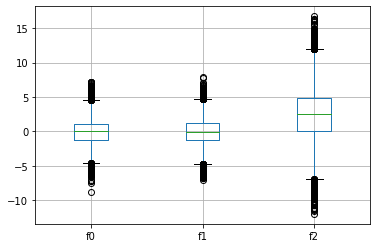

In [34]:
geo_gata_2.boxplot(['f0', 'f1', 'f2'])

В последнем датафрейме выбросы присутствуют в каждом столбце.

In [35]:
geo_gata_2 = remove_unnecessary(geo_gata_2, 'f0')

Количество удалённых строк: 733 или 0.7%


In [36]:
geo_gata_2 = remove_unnecessary(geo_gata_2, 'f1')

Количество удалённых строк: 682 или 0.7%


In [37]:
geo_gata_2 = remove_unnecessary(geo_gata_2, 'f2')

Количество удалённых строк: 582 или 0.6%


<AxesSubplot:>

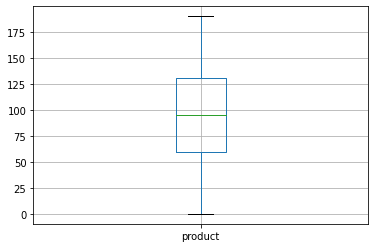

In [38]:
geo_gata_2.boxplot('product')

In [39]:
geo_gata_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000620,0.000466,-0.002948
f1,0.000620,1.000000,0.000693,-0.000930
f2,0.000466,0.000693,1.000000,0.441211
product,-0.002948,-0.000930,0.441211,1.000000


Есть умеренная кореляция столбца "f2" с целевым признаком.

Небольшое количество дубликатов было обнаружено в каждом наборе данных. Так как эта ошибка повторяется стоит обратить на это внимание тех кто отвечал за выгрузку. Из всех наборов данных были удалены выбросы. Больше всего их было в последнем датасете, но общее количество не превышает 2%. Так же была обнаружена сильная корреляция во втором датафрейме, один из признаков пришлось удалить.

## Обучение и проверка модели

Подготовим данные для обучения модели, отделим признаки для обучения от целевого признака. Чтобы не копировать один и тот же код, переберём датасеты циклом. И обучим модель. Для расчёта используем построение конвейера с помощью функции make_pipeline.

In [40]:
array_name = ['geo_data_0', 'geo_data_1', 'geo_data_2']
array_data = [geo_gata_0, geo_gata_1, geo_gata_2]

data_dict = {'valid':{}, 'predict':{}}

for data, name in zip(array_data, array_name):
    
    features = data.drop(['id', 'product'], axis = 1)
    target = data['product']
    
    new_pipeline = make_pipeline(StandardScaler(), LinearRegression())
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size = 0.25, random_state = 12345)
    
    new_pipeline.fit(features_train, target_train)
    
    data_dict['valid'][name] = target_valid
    data_dict['predict'][name] = new_pipeline.predict(features_valid)
    
    print('Средний запас сырья реальный:', target_valid.mean())
    print('Средний запас сырья предсказанный:', data_dict['predict'][name].mean())
    print('RMSE', name, ':', mean_squared_error(target_valid, data_dict['predict'][name])**0.5)
    print()

Средний запас сырья реальный: 91.97774194745743
Средний запас сырья предсказанный: 92.59323413054406
RMSE geo_data_0 : 37.723754923964115

Средний запас сырья реальный: 68.63422477161956
Средний запас сырья предсказанный: 68.6386802421195
RMSE geo_data_1 : 0.8892698446231985

Средний запас сырья реальный: 94.9532506614464
Средний запас сырья предсказанный: 94.96694703867499
RMSE geo_data_2 : 40.01836830591263



Из полученных результатов делаем следующий вывод самый большой запас в последнем регионе, но средняя ошибка. Самый маленький запас в регионе "geo_data_1" и самая маленькая ошибка. Первый регион похож на последний, имеет запас немного меньший запас и немного нижне RMSE.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных константах. Константы принято именовать буквами в верхнем регистре с _ в качестве разделителя.

In [41]:
BUDGET = 10*(10**9) # Бюджет на разработку скважин в регионе — 10 млрд рублей
COST_PRE_POINT = 500 # При разведке региона исследуют 500 точек
COST_FIN_POINTS = 200 # 200 лучших для разработки скважин
PRODUCT_PRICE = 450000 # Доход с тысячи баррелей
DAMAGE_THRESHOLD = .025 # Порог вероятности убытков 2.5%

Имея данные для расчёта найдём точку безубыточности.

In [42]:
BREAK_EVEN = BUDGET // COST_PRE_POINT // PRODUCT_PRICE
BREAK_EVEN

44

Исходя из полученной точки безубыточности можем сделать вывод все регионы нам подходят.

## Расчёт прибыли и рисков 

In [43]:
def profit(target, predict):
    sort_Series = pd.Series(predict).sort_values(ascending=False)[:COST_FIN_POINTS]
    target_sort = (target.reset_index(drop = True)[sort_Series.index])
    sum_target = target_sort.sum() 
    return round((sum_target * PRODUCT_PRICE) - BUDGET, 2)

In [44]:
print('Прибыль с лучших 200 скважин в регионе geo_data_0:', profit(data_dict['valid']['geo_data_0'], data_dict['predict']['geo_data_0']))
print('Прибыль с лучших 200 скважин в регионе geo_data_1:', profit(data_dict['valid']['geo_data_1'], data_dict['predict']['geo_data_1']))
print('Прибыль с лучших 200 скважин в регионе geo_data_2:', profit(data_dict['valid']['geo_data_2'], data_dict['predict']['geo_data_2']))


Прибыль с лучших 200 скважин в регионе geo_data_0: 3267957892.71
Прибыль с лучших 200 скважин в регионе geo_data_1: 2415086696.68
Прибыль с лучших 200 скважин в регионе geo_data_2: 2182887800.68


In [45]:
def bootsrtap(target, predict):
    values = []
    for i in range(1000):
        sample = pd.Series(predict).sample(n = COST_PRE_POINT, replace=True, random_state=state)
        values.append(profit(target, sample))
    values = pd.Series(values)
    print('Средняя прибыль:', values.mean())
    print('Риски:', values.apply(lambda x: x < 0).sum()/len(values)*100,"%")
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    return round(lower, 2), round(upper, 2)

In [46]:
print("95% доверительный итервал для региона geo_data_0 лежит между:",
      bootsrtap(data_dict['valid']['geo_data_0'], data_dict['predict']['geo_data_0']))
print()
print("95% доверительный итервал для региона geo_data_1 лежит между:",
      bootsrtap(data_dict['valid']['geo_data_1'], data_dict['predict']['geo_data_1']))
print()
print("95% доверительный итервал для региона geo_data_2 лежит между:",
      bootsrtap(data_dict['valid']['geo_data_2'], data_dict['predict']['geo_data_2']))

Средняя прибыль: 378298087.95606005
Риски: 7.1 %
95% доверительный итервал для региона geo_data_0 лежит между: (-106768256.18, 852188552.91)

Средняя прибыль: 437922748.99982
Риски: 1.4000000000000001 %
95% доверительный итервал для региона geo_data_1 лежит между: (53792875.83, 849428261.54)

Средняя прибыль: 373744999.31156
Риски: 8.200000000000001 %
95% доверительный итервал для региона geo_data_2 лежит между: (-149193690.79, 942955061.63)


При написании проекта мы изучили 3 датасета по регионам. При предобработке были обнаружены дубликаты по имени скважины, были удалены. Были удалены выбросы и некоторых столбцов, максимальное значение потерь данных не превысило 2%. Во втором датасеты была обнаружена сильная корреляция столбца с целевым признаком, столбец был удалён. 
Далее разбили данные в соотношении 75:25 на тренировочную и валидационную выборки. Создали конвеер и обучили модель линейной регресси. Сделали предсказания и сравнили ошибки модели в разных регионах.

При подготовке данных для расчёта прибыли сохранили все значения в константы и нашли точку безубыточности.

Написали функцию подсчета прибыли для выбранных скважин. Отсеяли 200 шкважин из отсортированного списка. Методом bootstrap на 1000 выборок, нашли 95%-й доверительный интервал, среднюю прибыль и определили риски.

В результате расчёта делаем вывод что регион "geo_data_1" наиболее перпективен для разработки скважин, т.к. имеет наибольшую среднюю прибыль и значительно меньшие риски.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован